<a href="https://colab.research.google.com/github/mickeykubo/fastai-v1/blob/master/lesson3_camvid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image segmentation with CamVid

In [0]:
!pip3 install https://download.pytorch.org/whl/cu80/torch-1.0.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install fastai
!pip3 install Pillow==4.0.0

    100% |████████████████████████████████| 532.5MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5e778000 @  0x7f4b149582a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 2.0MB 9.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 153kB 6.8MB/s 
    100% |████████████████████████████████| 112kB 30.6MB/s 
  Running setup.py bdist_wheel for bottleneck ... - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/f2/bf/ec/e0f39aa27001525ad455139ee57ec7d0776fe074dfd78c97e4
  Running setup.py bdist_wheel for nvidia-ml-py3 .

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
#torch.cuda.set_device(3)

In [0]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [0]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [0]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0006R0_f01380.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f01350.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00270.png')]

In [0]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_06450_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_01230_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08013_P.png')]

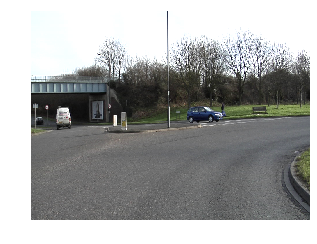

In [0]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

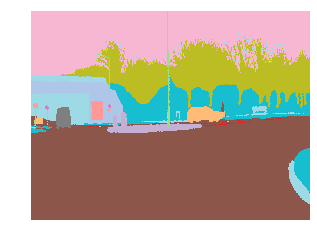

In [0]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [0]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [0]:
size = src_size//2
bs=8

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

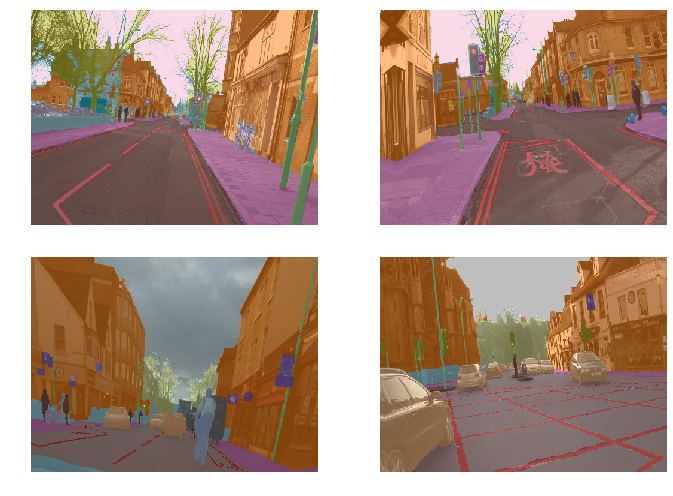

In [0]:
data.show_batch(2, figsize=(10,7))

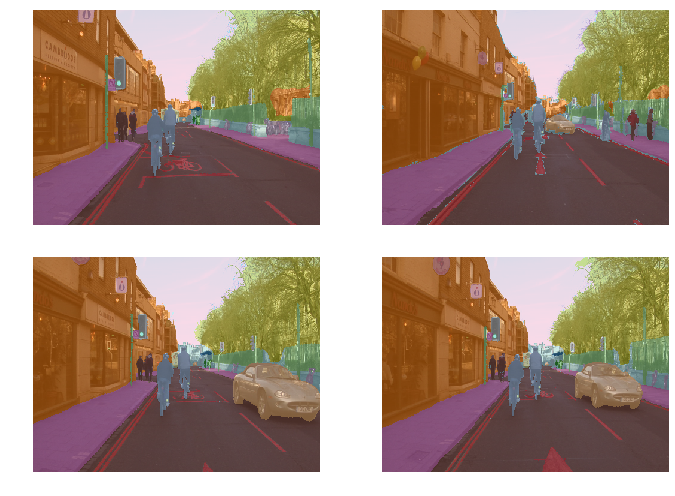

In [0]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:02<00:00, 29158176.80it/s]


In [0]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,acc_camvid


In [0]:
lr=3e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

Total time: 04:34
epoch  train_loss  valid_loss  acc_camvid
1      2.007691    1.135577    0.756788    (00:33)
2      1.120324    0.684148    0.836947    (00:26)
3      0.786669    0.604433    0.836660    (00:26)
4      0.640418    0.571276    0.846346    (00:26)
5      0.578618    0.462487    0.871583    (00:26)
6      0.539033    0.460834    0.869878    (00:27)
7      0.501951    0.374874    0.892722    (00:26)
8      0.467877    0.405072    0.897917    (00:26)
9      0.428562    0.420552    0.878152    (00:27)
10     0.383586    0.303194    0.916410    (00:27)



In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

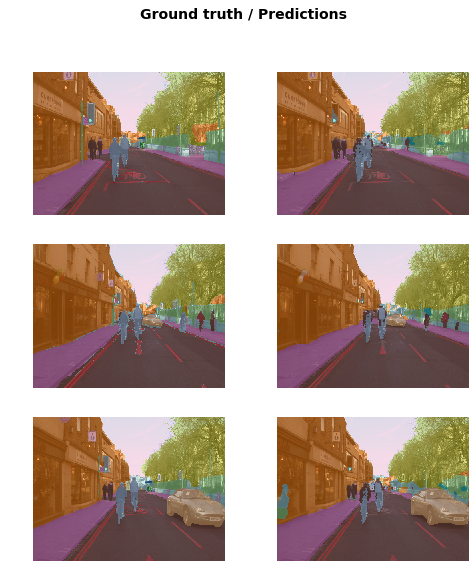

In [0]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

Total time: 05:41
epoch  train_loss  valid_loss  acc_camvid
1      0.371151    0.299532    0.913073    (00:28)
2      0.366780    0.294742    0.912834    (00:28)
3      0.358645    0.289903    0.914587    (00:28)
4      0.343787    0.283344    0.917667    (00:28)
5      0.335654    0.302039    0.910359    (00:28)
6      0.333715    0.279829    0.917886    (00:28)
7      0.319299    0.280948    0.919826    (00:28)
8      0.322344    0.307531    0.903787    (00:28)
9      0.308014    0.262560    0.925540    (00:28)
10     0.304060    0.293154    0.914199    (00:28)
11     0.285894    0.261870    0.923825    (00:28)
12     0.260680    0.255957    0.926067    (00:28)



In [0]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
size = src_size
bs=3

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


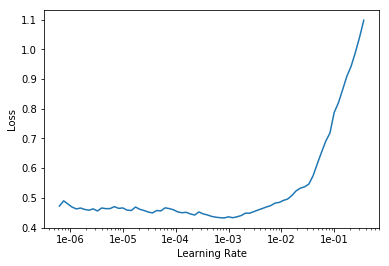

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

Total time: 15:41
epoch  train_loss  valid_loss  acc_camvid
1      0.382982    0.337384    0.904437    (01:40)
2      0.363525    0.312738    0.913709    (01:33)
3      0.345842    0.281208    0.918837    (01:33)
4      0.332908    0.315401    0.911936    (01:33)
5      0.337121    0.315564    0.911719    (01:33)
6      0.326914    0.283248    0.919347    (01:33)
7      0.311748    0.303021    0.913213    (01:33)
8      0.312433    0.264381    0.925357    (01:33)
9      0.274042    0.265071    0.921500    (01:33)
10     0.244084    0.239709    0.931215    (01:33)



In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

Total time: 16:49
epoch  train_loss  valid_loss  acc_camvid
1      0.224315    0.243748    0.929659    (01:39)
2      0.233819    0.256230    0.925163    (01:41)
3      0.216598    0.248363    0.929304    (01:41)
4      0.217467    0.242487    0.930903    (01:41)
5      0.221290    0.247053    0.930387    (01:41)
6      0.208421    0.249250    0.929263    (01:41)
7      0.202845    0.240715    0.931511    (01:41)
8      0.197734    0.244688    0.930260    (01:41)
9      0.195650    0.249368    0.929931    (01:40)
10     0.192460    0.248666    0.929322    (01:41)



In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big')

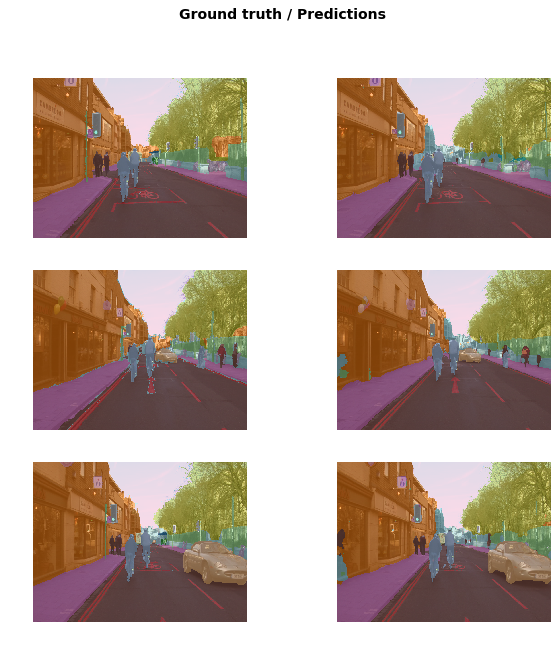

In [0]:
learn.show_results(rows=3, figsize=(10,10))

## fin